In [13]:
'''Prerequisites: 
The input dir must contain a folder of .tiff images and a run length encoding .csv file that corresponds with those images.
The RLE .csv files must have columns 'id' and 'predicted', and the ids must match the image names.

Items you have to update:
BASE_PATH
IMAGE_PATH
RLE_file_name
small_ids
image_id (if you want to inspect one more closely)

If your RLE .csv has different column names, change it in the read_image function.'''



"Prerequisites: \nThe input dir must contain a folder of .tiff images and a run length encoding .csv file that corresponds with those images.\nThe RLE .csv files must have columns 'id' and 'predicted', and the ids must match the image names.\n\nItems you have to update:\nBASE_PATH\nIMAGE_PATH\nRLE_file_name\nsmall_ids\n\nIf your RLE .csv has different column names, change it in the read_image function."

In [14]:
#import packages

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile

In [23]:
#identify directories

BASE_PATH = 'C:/Users/llschers/OneDrive - Indiana University/Documents/Kaggle/Colon Predictions/colon_prediction/1-tom/After-tuning-0.8799'

#set the folder of images you want to visualize
IMAGE_PATH = os.path.join(BASE_PATH, "test")

#set the RLE file you want to visualize
RLE_file_name = 'submission_colon.csv'

print(os.listdir(BASE_PATH))

['.ipynb_checkpoints', 'images', 'submission_colon.csv', 'test', 'train']


In [16]:
#masks

df_masks = pd.read_csv(
    os.path.join(BASE_PATH, RLE_file_name)
)
df_masks

,id,predicted
0,CL_HandE_1234_B004_bottomleft,453303 17 457837 24 462371 28 466905 31 471439...
1,HandE_B005_CL_b_RGB_bottomleft,13734858 6 13739389 15 13743923 19 13748457 23...


In [17]:
#number of masks

print(f"Number of masks: {df_masks.shape[0]}")

Number of masks: 2


In [18]:
#sample names
#these small_ids are the names of the images, minus the .tiff extention
small_ids = [
    "CL_HandE_1234_B004_bottomleft", "HandE_B005_CL_b_RGB_bottomleft"
]


In [19]:
#utility functions
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(IMAGE_PATH, f"{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_masks[df_masks["id"] == image_id]["predicted"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    
    w_len = image.shape[0]
    h_len = image.shape[1]
    
    min_len = min(w_len, h_len)
    w_start = (w_len - min_len) // 2
    h_start = (h_len - min_len) // 2
    
    plt.imshow(image[w_start : w_start + min_len, h_start : h_start + min_len])
    plt.imshow(
        mask[w_start : w_start + min_len, h_start : h_start + min_len], cmap="hot", alpha=0.5,
    )
    plt.axis("off")
            
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    plt.show()

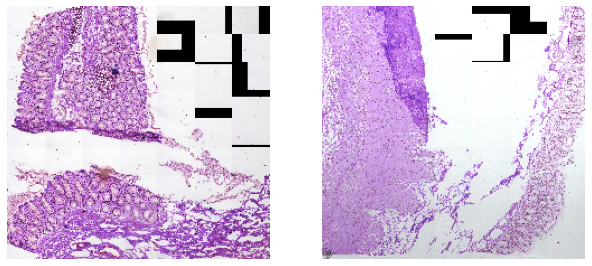

In [21]:
#show images
small_images = []
small_masks = []

for small_id in small_ids:
    tmp_image, tmp_mask = read_image(small_id, scale=20, verbose=0)
    small_images.append(tmp_image)
    small_masks.append(tmp_mask)

plt.figure(figsize=(16, 11))
for ind, (tmp_id, tmp_image) in enumerate(zip(small_ids, small_images)):
    plt.subplot(2, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.axis("off")

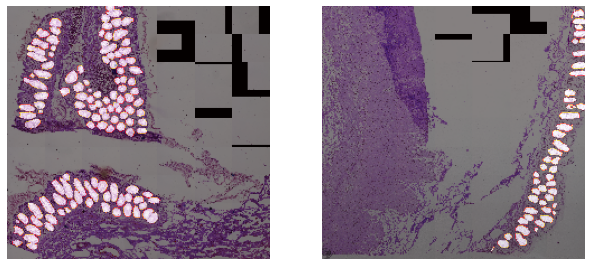

In [28]:
#show masks over images and save

plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image, tmp_mask) in enumerate(zip(small_ids, small_images, small_masks)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
plt.savefig(BASE_PATH+"/vis.png")

In [29]:
#inspect mask over image more closely

image_id = "CL_HandE_1234_B004_bottomleft"
image, mask = read_image(image_id, 2)


[CL_HandE_1234_B004_bottomleft] Image shape: (4536, 4704, 3)
[CL_HandE_1234_B004_bottomleft] Mask shape: (4536, 4704)
[CL_HandE_1234_B004_bottomleft] Resized Image shape: (2268, 2352, 3)
[CL_HandE_1234_B004_bottomleft] Resized Mask shape: (2268, 2352)


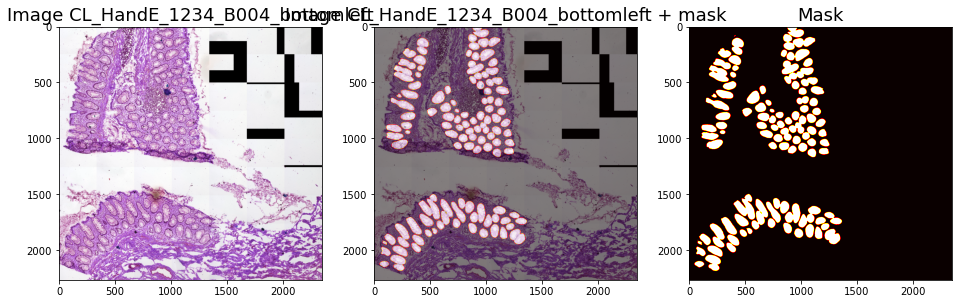

In [30]:
plot_image_and_mask(image, mask, image_id)

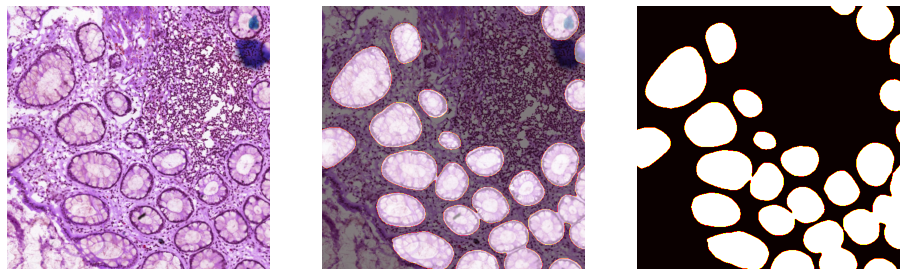

In [32]:
#change slice values to select where you want to zoom in
#plot_slice_image_and_mask(image, mask, top, bottom, left, right)
plot_slice_image_and_mask(image, mask, 500, 1000, 500, 1000)


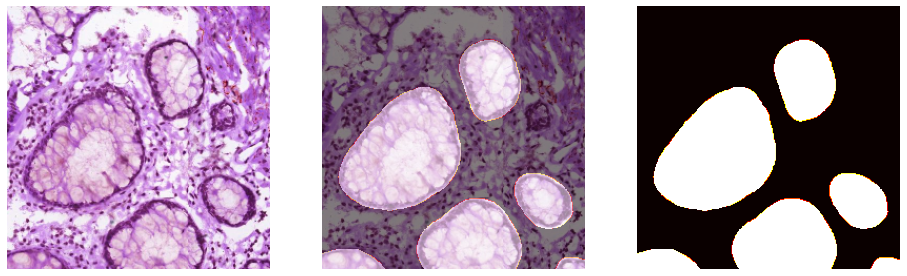

In [33]:
plot_slice_image_and_mask(image, mask, 500, 750, 500, 750)



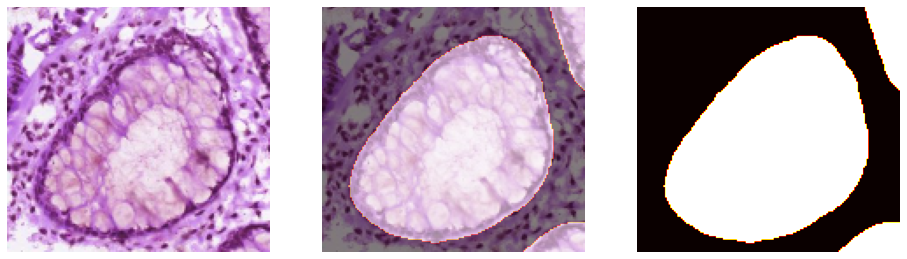

In [44]:
plot_slice_image_and_mask(image, mask, 560, 700, 500, 650)